In [9]:
import os
import time
import datetime
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import easydict
import network
import dataset
import utils
import wandb

import matplotlib.pyplot as plt

In [2]:

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_complex_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.amplitude_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
    
def plot_db_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
opt = easydict.EasyDict({
    "data_dir": '/data1/singing_inpainting/dataset',
    "input_length": 220500,
    "image_height": 1025,
    "image_width": 431,
    "bbox_shape": 120,
    "num_workers": 4,
    "batch_size": 8,
    "mask_type" : 'time',
    "load_name" : '/data2/personal/jaejun/inpainting/results/210719/time3/models/deepfillv2_WGAN_epoch115_batchsize4.pth',
    "sample_path" : '/data2/personal/jaejun/inpainting/results/210719/time3/validation26',
    "in_channels" : 2,
    "out_channels" : 1,
    "latent_channels" : 32,
    "pad_type": 'zero',
    "activation": 'lrelu',
    "norm": 'in',
    "mask_init": 'lerp',
    })

In [10]:
# class InpaintDataset(Dataset):
#     def __init__(self, opt, split):
#         self.opt = opt
#         self.split = split
#         self.pow_to_db = torchaudio.transforms.AmplitudeToDB('power')
#         self.get_list()
        
#     def __getitem__(self, index):
#         if self.split == 'TRAIN':
#             if self.opt.mask_type == 'time':
#                 mask = self.time_mask()
#             if self.opt.mask_type == 'bbox':
#                 mask = self.bbox2mask()
#             if self.opt.mask_type == 'freeform':
#                 mask = self.random_ff_mask()
#             audio = self.get_audio(index)
#         elif self.split in ['VALID', 'TEST']:
#             if self.opt.mask_type == 'time':
#                 masks_dir = '../split/fixedmask_time_2048'
#                 mask = np.load(os.path.join(masks_dir, str(index)) + '.npy')
#             if self.opt.mask_type == 'bbox':
#                 masks_dir = '../split/fixedmask_bbox_2048'
#                 mask = np.load(os.path.join(masks_dir, str(index)) + '.npy')
#             if self.opt.mask_type == 'freeform':
#                 masks_dir = '../split/fixedmask_freeform_2048'
#                 mask = np.load(os.path.join(masks_dir, str(index)) + '.npy')
#             audio = self.get_valid_audio(index)
#         # spec = self.get_comlex_spectrogram(audio)
#         spec = self.get_spectrogram(audio).unsqueeze(-1)
#         spec = self.pow_to_db(spec)
#         spec = spec.squeeze(0).permute(2, 0, 1).contiguous()
#         mask = torch.from_numpy(mask.astype(np.float32)).contiguous()
#         return audio, spec, mask

    
#     def get_list(self):
#         margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
#         margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
#         nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
#         nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
#         vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
#         vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

#         margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
#         nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
#         vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

#         if self.split == 'TRAIN':
#             train_list = self.dataset_merge(list(margs_train) + list(nuss_train) + list(vocals_train))
#             self.fl = train_list
#         elif self.split == 'VALID':
#             valid_list = self.dataset_merge(list(margs_valid) + list(nuss_valid) + list(vocals_valid))
#             self.fl = valid_list
#         elif self.split == 'TEST':
#             test_list = self.dataset_merge(list(margs_test) + list(nuss_test) + list(vocals_test))
#             self.fl = test_list
    
#     def dataset_merge(self, dataset):
#         merged_dataset = []
#         for ix, lis in enumerate(dataset):
#             dat = torchaudio.info(os.path.join(self.opt.data_dir, lis))
#             if dat.num_frames > 44100*2.5:
#                 merged_dataset.append(lis)
#         return merged_dataset

#     def get_audio(self, index):
#         fn = self.fl[index]
#         audio_path = os.path.join(self.opt.data_dir, fn)
#         num_frames = torchaudio.info(audio_path).num_frames
#         if num_frames <= self.opt.input_length:
#             audio, sr = torchaudio.load(audio_path)
#             audio = torch.nn.functional.pad(audio, (0, self.opt.input_length-num_frames), mode='constant', value=0)
#         else:
#             random_idx = np.random.randint(num_frames - self.opt.input_length)
#             audio, sr = torchaudio.load(audio_path, frame_offset=random_idx, num_frames=self.opt.input_length)
#         return audio

#     def get_valid_audio(self, index):
#         fn = self.fl[index]
#         audio_path = os.path.join(self.opt.data_dir, fn)
#         num_frames = torchaudio.info(audio_path).num_frames
#         if num_frames <= self.opt.input_length:
#             audio, sr = torchaudio.load(audio_path)
#             audio = torch.nn.functional.pad(audio, (0, self.opt.input_length-num_frames), mode='constant', value=0)
#         else:
#             audio, sr = torchaudio.load(audio_path, frame_offset=0, num_frames=self.opt.input_length)
#         return audio

#     def get_comlex_spectrogram(self, waveform, n_fft = 2048, win_len = 2048, hop_len = 512, power=None):
#         spectrogram = T.Spectrogram(
#         n_fft=n_fft,
#         win_length=win_len,
#         hop_length=hop_len,
#         center=True,
#         pad_mode="reflect",
#         power=power,
#         return_complex=0,
#         )
#         return spectrogram(waveform)

#     def get_spectrogram(self, waveform, n_fft = 2048, win_len = 2048, hop_len = 512, power=2):
#         spectrogram = T.Spectrogram(
#         n_fft=n_fft,
#         win_length=win_len,
#         hop_length=hop_len,
#         center=True,
#         pad_mode="reflect",
#         power=power,
#         )
#         return spectrogram(waveform)

#     def random_bbox(self):
#         max_freq_ix = self.opt.image_height - self.opt.bbox_shape
#         max_frame_ix = self.opt.image_width - self.opt.bbox_shape

#         box_freq_ix = np.random.randint(max_freq_ix)
#         box_frame_ix = np.random.randint(max_frame_ix)

#         return (box_freq_ix, box_frame_ix, self.opt.bbox_shape, self.opt.bbox_shape)

#     def time_mask(self):
#         mask_width = np.random.randint(low=8, high=87)
#         max_frame_ix = self.opt.image_width - mask_width
#         t = np.random.randint(max_frame_ix)
#         mask = np.zeros((self.opt.image_height, self.opt.image_width))
#         mask[:,t:t+mask_width] = 1
#         return mask.reshape((1, ) + mask.shape).astype(np.float32)

#     def bbox2mask(self):
#         bboxs = []
#         times = np.random.randint(8)
#         for i in range(times):
#             bbox = self.random_bbox()
#             bboxs.append(bbox)
#         mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
#         for bbox in bboxs:
#             h = int(bbox[2] * 0.1) + np.random.randint(int(bbox[2] * 0.2 + 1))
#             w = int(bbox[3] * 0.1) + np.random.randint(int(bbox[3] * 0.2) + 1)
#             mask[(bbox[0] + h) : (bbox[0] + bbox[2] - h), (bbox[1] + w) : (bbox[1] + bbox[3] - w)] = 1.
#         return mask.reshape((1, ) + mask.shape).astype(np.float32)

#     def random_ff_mask(self):
#         """Generate a random free form mask with configuration.
#         Args:
#             config: Config should have configuration including IMG_SHAPES,
#                 VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
#         Returns:
#             tuple: (top, left, height, width)
#         """
#         mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
#         max_angle = 4
#         max_len = 200
#         max_width = 20
#         times = np.random.randint(7)
#         for i in range(times):
#             start_x = np.random.randint(self.opt.image_width)
#             start_y = np.random.randint(self.opt.image_height)
#             for j in range(1 + np.random.randint(5)):
#                 angle = 0.01 + np.random.randint(max_angle)
#                 if i % 2 == 0:
#                     angle = 2 * 3.1415926 - angle
#                 length = 10 + np.random.randint(max_len)
#                 brush_w = 5 + np.random.randint(max_width)
#                 end_x = (start_x + length * np.sin(angle)).astype(np.int32)
#                 end_y = (start_y + length * np.cos(angle)).astype(np.int32)
#                 cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
#                 start_x, start_y = end_x, end_y
#         return mask.reshape((1, ) + mask.shape).astype(np.float32)

#     def __len__(self):
#         return len(self.fl)

In [141]:
audio = testset[0][0]
spec = testset[0][1]
mask = testset[0][2]
audio.shape, spec.shape, mask.shape

(torch.Size([1, 220500]),
 torch.Size([1, 1025, 431]),
 torch.Size([1, 1025, 431]))

In [142]:
spec_pad = torch.nn.functional.pad(spec, (1, 1, 0, 0), mode='constant', value=0)
spec_pad.shape, mask.shape

(torch.Size([1, 1025, 433]), torch.Size([1, 1025, 431]))

In [143]:
mask_range = torch.where(mask[:,0,:]==1)
start = torch.min(mask_range[-1])
end = torch.max(mask_range[-1])
merged = torch.cat([spec_pad[:,:,start], spec_pad[:,:,end+2]], 0)
lerp = torch.nn.functional.interpolate(merged.permute(1, 0).unsqueeze(0), size=end-start+1, mode='linear')
lerp_mask = torch.zeros(mask.shape)
lerp_mask[:, :, start:end+1] = lerp

In [6]:
# for testing
trainset = dataset.InpaintDataset(opt, split='TRAIN')
dataloader = DataLoader(trainset, batch_size = opt.batch_size, shuffle = True, num_workers = opt.num_workers, pin_memory = True, worker_init_fn = lambda _: np.random.seed())

In [12]:
audio, spec, mask, lerp_mask = trainset[0]


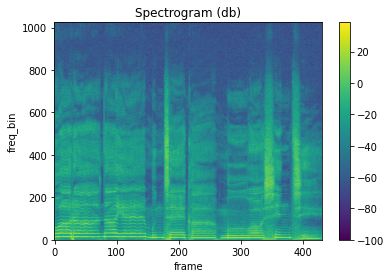

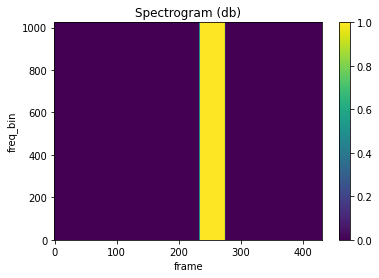

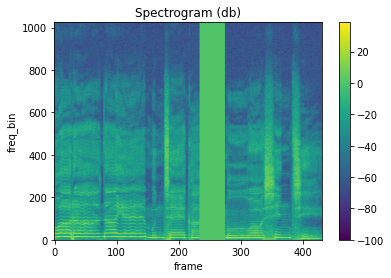

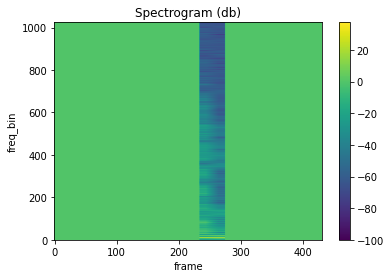

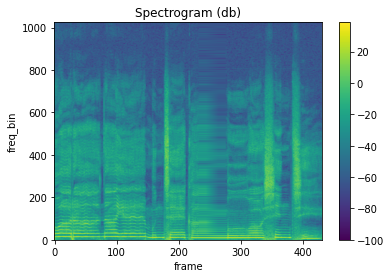

In [16]:
plot_db_spectrogram(spec[0])
plot_db_spectrogram(mask[0])
plot_db_spectrogram((spec*(1-mask) + mask)[0])
plot_db_spectrogram(lerp_mask[0])
plot_db_spectrogram((spec*(1-mask) + lerp_mask)[0])

In [50]:
import skimage.measure

def psnr(pred, target, pixel_max_cnt = 100):
    mse = torch.mul(target - pred, target - pred)
    rmse_avg = (torch.mean(mse).item()) ** 0.5
    p = 20 * np.log10(pixel_max_cnt / rmse_avg)
    return p

def ssim(pred, target):
    pred = pred.clone().data.permute(0, 2, 3, 1).cpu().numpy()
    target = target.clone().data.permute(0, 2, 3, 1).cpu().numpy()
    target = target[0]
    pred = pred[0]
    ssim = skimage.measure.compare_ssim(target, pred, multichannel = True)
    return ssim


In [59]:
a = spec.unsqueeze(0)
b = (spec*(1-mask) + lerp_mask).unsqueeze(0)
c = (spec*(1-mask) + mask).unsqueeze(0)
a.shape, b.shape
print(psnr(spec*mask, mask) / mask.sum() * 1000, psnr(spec*mask, lerp_mask) / mask.sum() * 1000)
print(ssim(spec*mask.unsqueeze(0), mask.unsqueeze(0)) / mask.sum() * 1000, ssim(spec*mask.unsqueeze(0), lerp_mask.unsqueeze(0)) / mask.sum() * 1000)


tensor(0.3915) tensor(0.7396)
tensor(0.0212) tensor(0.0219)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [61]:
100000/3300

30.303030303030305